In [85]:
import os
from venv import create

import numpy as np
import pandas as pd
import seaborn as sns
from rdkit import Chem
from py2sambvca import p2s
import matplotlib.pyplot as plt
from rdkit.Chem import rdMolTransforms
from rdkit.Chem import rdDetermineBonds

In [2]:
METAL_ATOMS = ["Fe", "Ru", "Os", "Co", "Rh", "Ir", "Ni", "Pd", "Pt", "Cu", "Ag", "Au"]

In [23]:
file = "xyz/2-QIXFIM.xyz"
with open(file, "r") as f:
    lines = f.readlines()[2:]
atoms = [line.split()[0] for line in lines]
metal_center = [i + 1 for i, atom in enumerate(atoms) if atom in METAL_ATOMS]
phosphorus_list = [i + 1 for i, atom in enumerate(atoms) if atom == "P"]
test_p2s = p2s(
    xyz_filepath=file,
    sphere_center_atom_ids=metal_center,
    z_ax_atom_ids=phosphorus_list,
    xz_plane_atoms_ids=[phosphorus_list[0]],
    atoms_to_delete_ids=metal_center,
    mesh_size=0.05,
    remove_H=0,
    verbose=2
)

In [47]:
output = test_p2s.run()

In [60]:
total_volume = output[0]["total_volume"]
percent_buried_volume = output[0]["percent_buried_volume"]
percent_buried_volume_sw = output[1]["percent_buried_volume"]["SW"]
percent_buried_volume_nw = output[1]["percent_buried_volume"]["NW"]
percent_buried_volume_se = output[1]["percent_buried_volume"]["SE"]
percent_buried_volume_ne = output[1]["percent_buried_volume"]["NE"]
dict = {"%Vbur": percent_buried_volume, "Total Volume": total_volume, "%Vbur SW": percent_buried_volume_sw, "%Vbur NW": percent_buried_volume_nw, "%Vbur SE": percent_buried_volume_se, "%Vbur NE": percent_buried_volume_ne}
pd.DataFrame(dict)

,%Vbur,Total Volume,%Vbur SW,%Vbur NW,%Vbur SE,%Vbur NE
0,42.7,179.5,48.7,38.3,37.9,45.9


In [132]:
xyz_list = []
xyz_files = [f for f in os.listdir("xyz")]
for xyz in xyz_files:
    name = xyz.strip(".xyz")
    xyz_path = "xyz/" + xyz
    
    mol = Chem.MolFromXYZFile(xyz_path)
    rdDetermineBonds.DetermineConnectivity(mol)
    metal = [a for a in mol.GetAtoms() if a.GetSymbol() in METAL_ATOMS][0]
    phosphorus_list = sorted([a for a in mol.GetAtoms() if a.GetSymbol() == "P"], key=lambda x: x.GetIdx())
    p1, p2 = phosphorus_list[0], phosphorus_list[1]
    p1_m_dist = rdMolTransforms.GetBondLength(mol.GetConformer(), p1.GetIdx(), metal.GetIdx())
    p2_m_dist = rdMolTransforms.GetBondLength(mol.GetConformer(), p2.GetIdx(), metal.GetIdx())
    bite_angle = rdMolTransforms.GetAngleDeg(mol.GetConformer(), p1.GetIdx(), metal.GetIdx(), p2.GetIdx())
    p_m_dist_avg = np.average([p1_m_dist, p2_m_dist])

    p1_neighbors = set(map(lambda x: x.GetIdx(), p1.GetNeighbors()))
    p2_neighbors = set(map(lambda x: x.GetIdx(), p2.GetNeighbors()))
    intersection = list(p1_neighbors.intersection(p2_neighbors))
    intersection_atoms = list(map(lambda x: mol.GetAtomWithIdx(x), intersection))
    bridge = next(atom.GetSymbol() for atom in intersection_atoms if atom.GetSymbol() not in METAL_ATOMS)
    
    with open(xyz_path, "r") as f:
        lines = f.readlines()[2:]
    atoms = [line.split()[0] for line in lines]
    metal_center = [i + 1 for i, atom in enumerate(atoms) if atom in METAL_ATOMS]
    phosphorus_list = [i + 1 for i, atom in enumerate(atoms) if atom == "P"]
    test_p2s = p2s(
        xyz_filepath=xyz_path,
        sphere_center_atom_ids=metal_center,
        z_ax_atom_ids=phosphorus_list,
        xz_plane_atoms_ids=[phosphorus_list[0]],
        atoms_to_delete_ids=metal_center,
        mesh_size=0.05,
        remove_H=0,
    )
    output = test_p2s.run()
    total_volume = output[0]["total_volume"]
    percent_buried_volume = output[0]["percent_buried_volume"]
    percent_buried_volume_sw = output[1]["percent_buried_volume"]["SW"]
    percent_buried_volume_nw = output[1]["percent_buried_volume"]["NW"]
    percent_buried_volume_se = output[1]["percent_buried_volume"]["SE"]
    percent_buried_volume_ne = output[1]["percent_buried_volume"]["NE"]
    
    xyz_list.append({"Name": name, "%Vbur": percent_buried_volume, "Total Volume": total_volume, "%Vbur SW": percent_buried_volume_sw, "%Vbur NW": percent_buried_volume_nw, "%Vbur SE": percent_buried_volume_se, "%Vbur NE": percent_buried_volume_ne, "Bite angle": bite_angle, "P1–M (Å)": p1_m_dist, "P2–M (Å)": p2_m_dist, "Avg. P–M (Å)": p_m_dist_avg, "Bridging atom": bridge, "Metal center": metal.GetSymbol()})

df = pd.DataFrame(xyz_list)
df

,Name,%Vbur,Total Volume,%Vbur SW,%Vbur NW,%Vbur SE,%Vbur NE,Bite angle,P1–M (Å),P2–M (Å),Avg. P–M (Å),Bridging atom,Metal center
0,AHAZOY,43.4,179.5,40.7,45.1,42.8,45.2,69.265307,2.245301,2.280631,2.262966,N,Ru
1,BEPSUL,46.4,179.5,44.0,49.5,43.6,48.6,72.113215,2.199866,2.201405,2.200636,N,Pt
2,BEPTAS,46.2,179.5,43.5,49.4,43.5,48.4,71.777082,2.210521,2.217296,2.213909,N,Pd
3,BEWPEZ,47.0,179.5,46.5,42.9,51.5,46.9,72.580939,2.340653,2.281635,2.311144,C,Rh
4,EHERIT,46.2,179.5,52.0,45.6,45.4,41.9,70.044749,2.289198,2.336384,2.312791,N,Rh
5,FEHWAT,45.2,179.5,40.9,46.3,44.2,49.4,68.847850,2.390475,2.311963,2.351219,N,Rh
6,FEHWEX,45.5,179.5,41.0,46.3,45.1,49.7,68.849800,2.368436,2.305312,2.336874,N,Ir
7,FEHWIB,44.8,179.5,48.0,45.6,45.5,40.2,68.354904,2.329339,2.393046,2.361193,N,Ru
8,MOXFAJ,47.5,179.5,48.3,41.9,52.5,47.3,72.500757,2.352306,2.287770,2.320038,C,Rh
9,MUDCOF,48.8,179.5,44.6,42.8,53.3,54.3,73.738348,2.259627,2.161980,2.210804,C,Pt


In [46]:
df.to_excel("review_params.xlsx", index=False)

In [173]:
# Define color mapping for bridging_atom
color_map = {
    'C': '#3498DB',
    'N': '#E74C3C',
}

def create_3d_scatter(ax, x, y, z, xlabel, ylabel, zlabel, text=False):
    for i, row in df.iterrows():
        ax.scatter(
            row[x], row[y], row[z],
            color=color_map[row['Bridging atom']],
            s=100,  # Marker size
            edgecolor='black',  # Add edge to markers
            linewidth=0.6
        )
        if text:
            ax.text(
                row[x], row[y], row[z] + 0.01,
                s= "L" + str(i + 1),
                fontsize=12,
                color='black',
                ha='center',
                va='bottom'
            )

    # Set labels
    ax.set_xlabel(xlabel, fontsize=14, labelpad=10)
    ax.set_ylabel(ylabel, fontsize=14, labelpad=10)
    ax.set_zlabel(zlabel, fontsize=14, labelpad=10)

    # Reduce empty space by adjusting axis limits
    ax.set_xlim(df[x].min() - 1, df[x].max() + 1)  # Add small margin
    ax.set_ylim(df[y].min(), df[y].max())  # Add small margin
    ax.set_zlim(df[z].min(), df[z].max())  # Add small margin

    # ax.tick_params(axis='both', which='major', labelsize=16)
    
def create_2d_scatter(ax, x, y, xlabel, ylabel, label_offset = 0, text=False):
    for i, row in df.iterrows():
        ax.scatter(
            row[x], row[y],
            color=color_map[row['Bridging atom']],
            s=120,  # Marker size
            edgecolor='black',  # Add edge to markers
            linewidth=0.6
        )
        if text:
            ax.text(
                row[x], row[y] + label_offset, "L" + str(i + 1),
                fontsize=12,
                color='black',
                ha='center',
                va='bottom'
            )
    ax.set_xlabel(xlabel, fontsize=20, labelpad=20)
    ax.set_ylabel(ylabel, fontsize=20, labelpad=20)
    
    # ax.grid(True, linestyle='--', alpha=0.6)
    ax.tick_params(axis='both', which='major', labelsize=16)
    sns.despine(ax=ax)  # Removes top and right spines

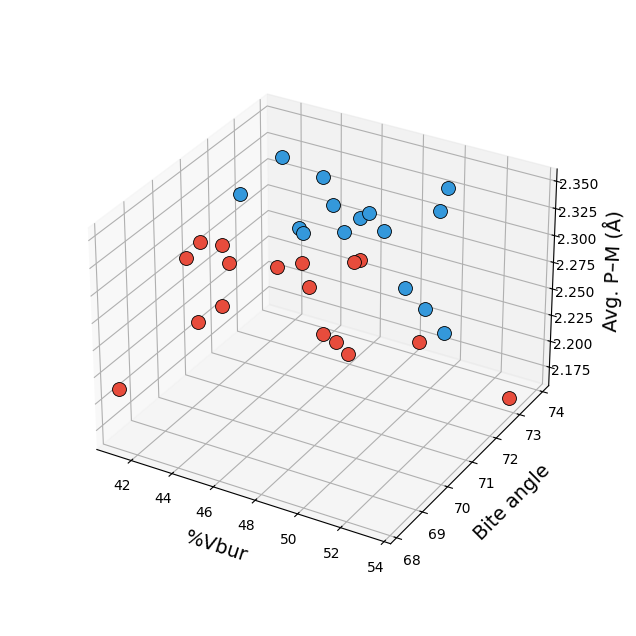

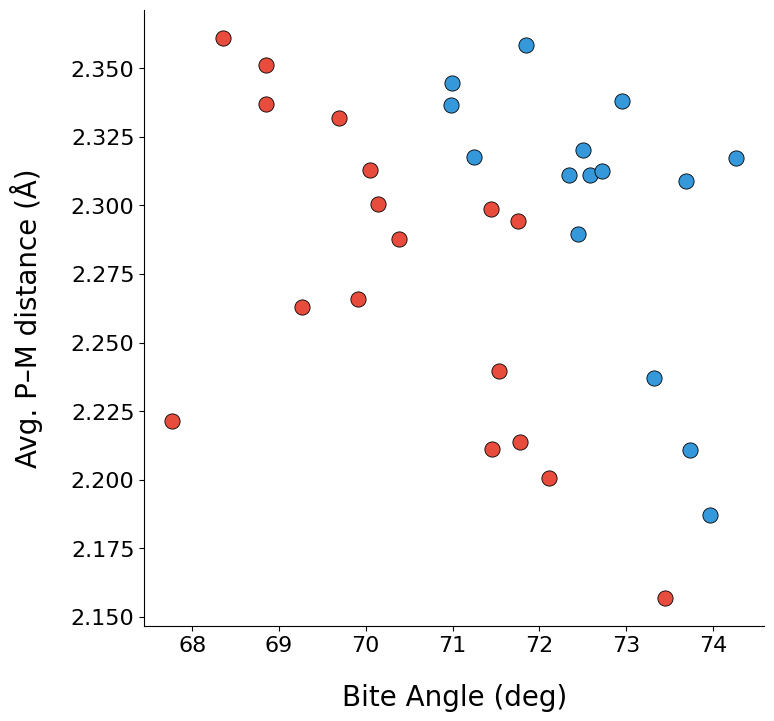

In [174]:
fig = plt.figure(figsize=(10, 8), facecolor="white")

ax1 = fig.add_subplot(111, projection='3d')
create_3d_scatter(ax1, '%Vbur', 'Bite angle', 'Avg. P–M (Å)', '%Vbur', 'Bite angle', 'Avg. P–M (Å)')
ax1.set_box_aspect(None, zoom=0.85)
plt.show()

fig = plt.figure(figsize=(8, 8), facecolor="white")
ax2 = fig.add_subplot(111)
create_2d_scatter(ax2, 'Bite angle', 'Avg. P–M (Å)', 'Bite Angle (deg)', 'Avg. P–M distance (Å)', 0.005)
plt.show()

# TODO: Add dividing line on 2D plot